The tuning process in this notebook is similar to the one executed in the daily notebook, so fewer explanations will be written throughout this notebook. For a more detailed explanation of the thought-processes behind tuning, see the daily notebook.

## Import Libraries and Load Data

In [1]:
import pandas as pd
from prophet import Prophet
import modules.preprocessing as prep
import modules.modeling as mdl
import modules.evaluation as ev
import os

In [2]:
# Load dataset
df = prep.load_dataset('../data/SN_y_tot_V2.0.csv')
df

,year,predicted_sunspots
0,1700.5,8.3
1,1701.5,18.3
2,1702.5,26.7
3,1703.5,38.3
4,1704.5,60.0
...,...,...
317,2017.5,21.7
318,2018.5,7.0
319,2019.5,3.6
320,2020.5,8.8


In [3]:
# Create formatted dataframe for use by Prophet and extract periodicity for forecasting
periodic_df, periodicity = prep.create_periodic_dataframe(df)

# Need to truncate data since the date ranges are too long to convert to
# 32 bit integer data type at nanosecond precision (which is what Prophet uses)
periodic_df = periodic_df[periodic_df.ds >= pd.to_datetime('1750-01-01')].reset_index(drop = True)
periodic_df

,ds,y
0,1750-01-01,139.0
1,1751-01-01,79.5
2,1752-01-01,79.7
3,1753-01-01,51.2
4,1754-01-01,20.3
...,...,...
267,2017-01-01,21.7
268,2018-01-01,7.0
269,2019-01-01,3.6
270,2020-01-01,8.8


In [4]:
# Define future periods to forecast and base paths for saving models and forecasts
future_periods = [1, 10, 20]
models_base_path = os.path.join('..', 'models', 'yearly')
forecasts_base_path = os.path.join('..', 'forecasts', 'yearly')

## Base Model Statistics

In [5]:
# Fit base model
model_name = 'base_yearly'
model_path = os.path.join(models_base_path, model_name + '.pickle')
forecast_path = os.path.join(forecasts_base_path, model_name + '.pickle')

base_params = {'df': periodic_df, 'func': Prophet}
func_params = {}
seasonality_params = {}
save_params = {'save': True, 'save_path': model_path}
fc_params = {'future_periods': future_periods[-1], 'periodicity': periodicity, 'cap': None}

# mdl.fit_model(func_params = func_params, seasonality_params = seasonality_params,
#               **base_params, **save_params, **fc_params);

In [6]:
# Calculate base model metrics
model = ev.load_pickle(model_path)
forecast = ev.load_pickle(forecast_path)
ev.calculate_errors(periodic_df, forecast[0])

Pickled object at ../models/yearly/base_yearly.pickle loaded successfully.
Pickled object at ../forecasts/yearly/base_yearly.pickle loaded successfully.


,mae,mape,r2
Model Errors,51.93559,2.29191,0.000157


## Model Tuning

Naming scheme:\
{sampling frequency}\_\_s-{seaonality_params}\_\_-g-{growth_type}\_\_-cp-{changepoint_prior}\_\_cn-{num_changepoints}.pickle\
Multiple params of same type separated by single _\
s = custom seasonality in form KyPf where K is the number of years and P is the Fourier Order\
g = growth type, default linear\
cp = changepoint prior frequency as a percent, default 5%\
cn = number of changepoints, default 25

## Tuning Seasonality

### 11 Years Custom Seasonality, Differing Fourier Orders

Note that Prophet requires seasonalities to be specified in days, regardless of the frequency of the fitted dataset. Thus, the period is still 4017.75.

In [7]:
# Test on Fourier Order 5, 10, 40, 80, 160, 240, 320, 360, and 400
fourier_orders = [5, 10, 40, 80, 160, 240, 320, 360, 400]
model_names = [f'yearly__s-11y{x}f__g-linear__cp-5__cn-25' for x in fourier_orders]
model_paths = [os.path.join(models_base_path, name + '.pickle') for name in model_names]
forecast_paths = [os.path.join(forecasts_base_path, name + '.pickle') for name in model_names]

base_params = {'df': periodic_df, 'func': Prophet}
func_params = {'yearly_seasonality': False}
fc_params = {'future_periods': future_periods[-1], 'periodicity': periodicity, 'cap': None}

# for i in range(len(model_names)):
#     seasonality_params = {f'11 Year, Fourier {fourier_orders[i]}':
#                               {'period': 4017.75, 'fourier_order': fourier_orders[i]}}
#     save_params = {'save': True, 'save_path': model_paths[i]}
#     mdl.fit_model(func_params = func_params, seasonality_params = seasonality_params,
#                   **base_params, **save_params, **fc_params);

The size of the dataset is much lower which makes training the model take less time. The model improves until Fourier order 360, then starts to stagnate, so Fourier order 360 will be used moving forward.

In [8]:
# Compare model metrics for different Fourier orders
models = [ev.load_pickle(p) for p in model_paths]
forecasts = [ev.load_pickle(p) for p in forecast_paths]
obs_preds_names = [(periodic_df, forecasts[i][0], list(models[i].seasonalities.keys())[0])
                   for i in range(len(forecasts))]

ev.multi_model_errors(obs_preds_names)

Pickled object at ../models/yearly/yearly__s-11y5f__g-linear__cp-5__cn-25.pickle loaded successfully.
Pickled object at ../models/yearly/yearly__s-11y10f__g-linear__cp-5__cn-25.pickle loaded successfully.
Pickled object at ../models/yearly/yearly__s-11y40f__g-linear__cp-5__cn-25.pickle loaded successfully.
Pickled object at ../models/yearly/yearly__s-11y80f__g-linear__cp-5__cn-25.pickle loaded successfully.
Pickled object at ../models/yearly/yearly__s-11y160f__g-linear__cp-5__cn-25.pickle loaded successfully.
Pickled object at ../models/yearly/yearly__s-11y240f__g-linear__cp-5__cn-25.pickle loaded successfully.
Pickled object at ../models/yearly/yearly__s-11y320f__g-linear__cp-5__cn-25.pickle loaded successfully.
Pickled object at ../models/yearly/yearly__s-11y360f__g-linear__cp-5__cn-25.pickle loaded successfully.
Pickled object at ../models/yearly/yearly__s-11y400f__g-linear__cp-5__cn-25.pickle loaded successfully.
Pickled object at ../forecasts/yearly/yearly__s-11y5f__g-linear__cp-5

,mae,mape,r2
"11 Year, Fourier 5",41.554220,1.610405,0.276006
"11 Year, Fourier 10",41.527970,1.606674,0.276090
"11 Year, Fourier 40",40.664630,1.568737,0.311226
"11 Year, Fourier 80",40.804000,1.563519,0.336558
"11 Year, Fourier 160",40.350740,1.515924,0.354483
"11 Year, Fourier 240",38.520737,1.372553,0.402245
"11 Year, Fourier 320",38.076284,1.346630,0.407129
"11 Year, Fourier 360",37.926343,1.337344,0.408994
"11 Year, Fourier 400",37.853342,1.340242,0.412597


## Tuning Forecasting Growth Type

### Logistic Growth

In [9]:
# The maximum value in the dataset is 269.3, and based on observations of the entire dataset
# 300 seems like a reasonable capacity for the number of daily sunspots
periodic_df.max()

ds    2021-01-01 00:00:00
y                   269.3
dtype: object

In [10]:
# Training the data using logistic growth
cap = 300
periodic_with_cap = periodic_df.copy()
periodic_with_cap['cap'] = cap

model_name = 'yearly__s-11y360f__g-logistic__cp-5__cn-25'
model_path = os.path.join(models_base_path, model_name + '.pickle')
forecast_path = os.path.join(forecasts_base_path, model_name + '.pickle')

base_params = {'df': periodic_with_cap, 'func': Prophet}
func_params = {'yearly_seasonality': False, 'growth': 'logistic'}
seasonality_params = {'11 Year, Fourier 360': {'period': 4017.75, 'fourier_order': 360}}
save_params = {'save': True, 'save_path': model_path}
fc_params = {'future_periods': future_periods[-1], 'periodicity': periodicity, 'cap': cap}

# mdl.fit_model(func_params = func_params, seasonality_params = seasonality_params,
#               **base_params, **save_params, **fc_params);

### Flat Growth

In [11]:
# Training the data using flat growth
model_name = 'yearly__s-11y360f__g-flat__cp-5__cn-25'
model_path = os.path.join(models_base_path, model_name + '.pickle')
forecast_path = os.path.join(forecasts_base_path, model_name + '.pickle')

base_params = {'df': periodic_with_cap, 'func': Prophet}
func_params = {'yearly_seasonality': False, 'growth': 'flat'}
seasonality_params = {'11 Year, Fourier 360': {'period': 4017.75, 'fourier_order': 360}}
save_params = {'save': True, 'save_path': model_path}
fc_params = {'future_periods': future_periods[-1], 'periodicity': periodicity, 'cap': None}

# mdl.fit_model(func_params = func_params, seasonality_params = seasonality_params,
#               **base_params, **save_params, **fc_params);

### Comparing Growth Types

Flat performs best, unlike the daily or monthly data. Note, however, that a flat growth type means that the trend is assumed to be stationary (hence, flat), and further tuning would be irrelevant. Further tuning will still use the linear growth type and will be compared to the flat growth model at the end.

In [12]:
# Comparing different model performance using different growth types
growth_types = ['linear', 'logistic', 'flat']
model_names = [f'yearly__s-11y360f__g-{x}__cp-5__cn-25' for x in growth_types]
model_paths = [os.path.join(models_base_path, name + '.pickle') for name in model_names]
forecast_paths = [os.path.join(forecasts_base_path, name + '.pickle') for name in model_names]
models = [ev.load_pickle(p) for p in model_paths]
forecasts = [ev.load_pickle(p) for p in forecast_paths]
obs_preds_names = [(periodic_df, forecasts[i][0],
                    f'{growth_types[i].title()} Growth')
                   for i in range(len(forecasts))]
ev.multi_model_errors(obs_preds_names)

Pickled object at ../models/yearly/yearly__s-11y360f__g-linear__cp-5__cn-25.pickle loaded successfully.
Pickled object at ../models/yearly/yearly__s-11y360f__g-logistic__cp-5__cn-25.pickle loaded successfully.
Pickled object at ../models/yearly/yearly__s-11y360f__g-flat__cp-5__cn-25.pickle loaded successfully.
Pickled object at ../forecasts/yearly/yearly__s-11y360f__g-linear__cp-5__cn-25.pickle loaded successfully.
Pickled object at ../forecasts/yearly/yearly__s-11y360f__g-logistic__cp-5__cn-25.pickle loaded successfully.
Pickled object at ../forecasts/yearly/yearly__s-11y360f__g-flat__cp-5__cn-25.pickle loaded successfully.


,mae,mape,r2
Linear Growth,37.926343,1.337344,0.408994
Logistic Growth,38.058267,1.360927,0.400279
Flat Growth,36.264472,1.319558,0.448117


## Tuning Trend Changepoints

### Changepoint Prior Scale

In [13]:
# Test on changepoint prior scales of 0.01, 0.02, 0.1, 0.25, 0.5, 0.8
cp_priors = [0.01, 0.02, 0.1, 0.25, 0.5, 0.8]
model_names = [f'yearly__s-11y360f__g-linear__cp-{int(x * 100)}__cn-25' for x in cp_priors]
model_paths = [os.path.join(models_base_path, name + '.pickle') for name in model_names]
forecast_paths = [os.path.join(forecasts_base_path, name + '.pickle') for name in model_names]
seasonality_params = {'11 Year, Fourier 360': {'period': 4017.75, 'fourier_order': 360}}
base_params = {'df': periodic_df, 'func': Prophet}
fc_params = {'future_periods': future_periods[-1], 'periodicity': periodicity, 'cap': None}

# for i in range(len(model_names)):
#     func_params = {'yearly_seasonality': False, 'changepoint_prior_scale': cp_priors[i]}
#     save_params = {'save': True, 'save_path': model_paths[i]}
#     mdl.fit_model(func_params = func_params, seasonality_params = seasonality_params,
#                   **base_params, **save_params, **fc_params);

The effectiveness of the models is struggling on the yearly sampled data, so even though a changepoint prior ratio of 0.8 is very high, it may be necessary to attain any reasonable results.

In [14]:
# Define base CP value model name and paths
base_cp_prior_name = 'yearly__s-11y360f__g-linear__cp-5__cn-25'
base_cp_prior_model_path = os.path.join(models_base_path, base_cp_prior_name + '.pickle')
base_cp_prior_forecast_path = os.path.join(forecasts_base_path, base_cp_prior_name + '.pickle')

# Load models and forecasts
models = [ev.load_pickle(p) for p in model_paths]
models.insert(0, ev.load_pickle(base_cp_prior_model_path))

forecasts = [ev.load_pickle(p) for p in forecast_paths]
forecasts.insert(0, ev.load_pickle(base_cp_prior_forecast_path))

# Calculate model metrics at different CP values
obs_preds_names = [(periodic_df, forecasts[i][0], f'Changepoint Prior {cp_priors[i - 1]}')
                   for i in range(1, len(forecasts))]
obs_preds_names.insert(2, (periodic_df, forecasts[0][0], f'Changepoint Prior 0.05, Default'))

ev.multi_model_errors(obs_preds_names)

Pickled object at ../models/yearly/yearly__s-11y360f__g-linear__cp-1__cn-25.pickle loaded successfully.
Pickled object at ../models/yearly/yearly__s-11y360f__g-linear__cp-2__cn-25.pickle loaded successfully.
Pickled object at ../models/yearly/yearly__s-11y360f__g-linear__cp-10__cn-25.pickle loaded successfully.
Pickled object at ../models/yearly/yearly__s-11y360f__g-linear__cp-25__cn-25.pickle loaded successfully.
Pickled object at ../models/yearly/yearly__s-11y360f__g-linear__cp-50__cn-25.pickle loaded successfully.
Pickled object at ../models/yearly/yearly__s-11y360f__g-linear__cp-80__cn-25.pickle loaded successfully.
Pickled object at ../models/yearly/yearly__s-11y360f__g-linear__cp-5__cn-25.pickle loaded successfully.
Pickled object at ../forecasts/yearly/yearly__s-11y360f__g-linear__cp-1__cn-25.pickle loaded successfully.
Pickled object at ../forecasts/yearly/yearly__s-11y360f__g-linear__cp-2__cn-25.pickle loaded successfully.
Pickled object at ../forecasts/yearly/yearly__s-11y360

,mae,mape,r2
Changepoint Prior 0.01,39.707067,1.482772,0.345445
Changepoint Prior 0.02,38.113590,1.344992,0.398857
"Changepoint Prior 0.05, Default",37.926343,1.337344,0.408994
Changepoint Prior 0.1,37.639908,1.333129,0.416701
Changepoint Prior 0.25,35.590750,1.268041,0.476206
Changepoint Prior 0.5,34.505988,1.221091,0.513395
Changepoint Prior 0.8,33.903762,1.205895,0.534631


### Number of Changepoints

In [15]:
# Test on changepoint numbers 30, 40, 50, 60, 70, 80, 90, 100, 120, and 140
cp_num = [30, 40, 50, 60, 70, 80, 90, 100, 120, 140]
model_names = [f'yearly__s-11y360f__g-linear__cp-80__cn-{x}' for x in cp_num]
model_paths = [os.path.join(models_base_path, name + '.pickle') for name in model_names]
forecast_paths = [os.path.join(forecasts_base_path, name + '.pickle') for name in model_names]
seasonality_params = {'11 Year, Fourier 360': {'period': 4017.75, 'fourier_order': 360}}
base_params = {'df': periodic_df, 'func': Prophet}
fc_params = {'future_periods': future_periods[-1], 'periodicity': periodicity, 'cap': None}

# for i in range(len(model_names)):
#     func_params = {'yearly_seasonality': False,
#                    'changepoint_prior_scale': 0.8, 'n_changepoints': cp_num[i]}
#     save_params = {'save': True, 'save_path': model_paths[i]}
#     mdl.fit_model(func_params = func_params, seasonality_params = seasonality_params,
#                   **base_params, **save_params, **fc_params);

Model performance increases until about 90 changepoints then levels off.

In [16]:
# Define base CN value model name and paths
cn_25_name = 'yearly__s-11y360f__g-linear__cp-80__cn-25'
cn_25_model_path = os.path.join(models_base_path, cn_25_name + '.pickle')
cn_25_forecast_path = os.path.join(forecasts_base_path, cn_25_name + '.pickle')

# Load models and forecasts
models = [ev.load_pickle(p) for p in model_paths]
models.insert(0, ev.load_pickle(cn_25_model_path))

forecasts = [ev.load_pickle(p) for p in forecast_paths]
forecasts.insert(0, ev.load_pickle(cn_25_forecast_path))

# Calculate model metrics for models with different CN values
obs_preds_names = [(periodic_df, forecasts[i][0], f'Changepoint Number {cp_num[i - 1]}')
                   for i in range(1, len(forecasts))]
obs_preds_names.insert(0, (periodic_df, forecasts[0][0], f'Changepoint Number 25, Default'))

ev.multi_model_errors(obs_preds_names)

Pickled object at ../models/yearly/yearly__s-11y360f__g-linear__cp-80__cn-30.pickle loaded successfully.
Pickled object at ../models/yearly/yearly__s-11y360f__g-linear__cp-80__cn-40.pickle loaded successfully.
Pickled object at ../models/yearly/yearly__s-11y360f__g-linear__cp-80__cn-50.pickle loaded successfully.
Pickled object at ../models/yearly/yearly__s-11y360f__g-linear__cp-80__cn-60.pickle loaded successfully.
Pickled object at ../models/yearly/yearly__s-11y360f__g-linear__cp-80__cn-70.pickle loaded successfully.
Pickled object at ../models/yearly/yearly__s-11y360f__g-linear__cp-80__cn-80.pickle loaded successfully.
Pickled object at ../models/yearly/yearly__s-11y360f__g-linear__cp-80__cn-90.pickle loaded successfully.
Pickled object at ../models/yearly/yearly__s-11y360f__g-linear__cp-80__cn-100.pickle loaded successfully.
Pickled object at ../models/yearly/yearly__s-11y360f__g-linear__cp-80__cn-120.pickle loaded successfully.
Pickled object at ../models/yearly/yearly__s-11y360f_

,mae,mape,r2
"Changepoint Number 25, Default",33.903762,1.205895,0.534631
Changepoint Number 30,33.720149,1.202139,0.539299
Changepoint Number 40,33.827819,1.203854,0.536065
Changepoint Number 50,33.784417,1.199809,0.535777
Changepoint Number 60,33.752808,1.199055,0.537286
Changepoint Number 70,33.662409,1.201494,0.538790
Changepoint Number 80,33.740317,1.199077,0.537285
Changepoint Number 90,33.692217,1.198048,0.538886
Changepoint Number 100,33.683562,1.198988,0.539374
Changepoint Number 120,33.660894,1.198042,0.539324


## Comparing Different Tuning Steps of Models

Tuning was able to increase the $R^2$ score immensely from 0.000157 to 0.5389. While the MAE is lower than the best daily model, the yearly model is significantly more complex (360 fourier order compared to 20, 0.8 checkpoint prior compared to 0.5, and 90 checkpoints compared to 80). The $R^2$ score for the best yearly model is significantly below that of the best daily model (0.5389 vs. 0.6132). This makes sense as the lower frequency of the yearly data means there are fewer large erorrs to inflate the average errors, but the model struggles to capture the underlying nature of the data due to fewer samples to use for regression. The MAPE for the best daily model is significantly lower then the MAPE for the best monthly model (0.621157 vs. 1.198048), indicating that when the magnitude of the data points is taken into account, the best daily model is significantly better.

In [17]:
# Load the best models at each step of the tuning process
model_names = [
    'base_yearly', 'yearly__s-11y360f__g-linear__cp-5__cn-25',
    'yearly__s-11y360f__g-flat__cp-5__cn-25',
    'yearly__s-11y360f__g-linear__cp-80__cn-25', 'yearly__s-11y360f__g-linear__cp-80__cn-90'
]
model_paths = [os.path.join(models_base_path, name + '.pickle') for name in model_names]
forecast_paths = [os.path.join(forecasts_base_path, name + '.pickle') for name in model_names]
models = [ev.load_pickle(p) for p in model_paths]
forecasts = [ev.load_pickle(p) for p in forecast_paths]

# Define model names and calculate model metrics for each step of the tuning process
model_titles = [
    'Base Untuned, G = Linear, CP = 0.05, CN = 25',
    'Seasonality-Tuned, S = 11y, 360f, G = Linear, CP = 0.05, CN = 25',
    'Growth-Tuned, S = 11y, 360f, G = Flat',
    'Changepoint Prior Tuned, S = 11y, 360f, G = Linear, CP = 0.8, CN = 25',
    'Changepoint Number Tuned, S = 11y, 360f, G = Linear, CP = 0.8, CN = 90'
]
obs_preds_names = [(periodic_df, forecasts[i][0], model_titles[i]) for i in range(len(forecasts))]

ev.multi_model_errors(obs_preds_names)

Pickled object at ../models/yearly/base_yearly.pickle loaded successfully.
Pickled object at ../models/yearly/yearly__s-11y360f__g-linear__cp-5__cn-25.pickle loaded successfully.
Pickled object at ../models/yearly/yearly__s-11y360f__g-flat__cp-5__cn-25.pickle loaded successfully.
Pickled object at ../models/yearly/yearly__s-11y360f__g-linear__cp-80__cn-25.pickle loaded successfully.
Pickled object at ../models/yearly/yearly__s-11y360f__g-linear__cp-80__cn-90.pickle loaded successfully.
Pickled object at ../forecasts/yearly/base_yearly.pickle loaded successfully.
Pickled object at ../forecasts/yearly/yearly__s-11y360f__g-linear__cp-5__cn-25.pickle loaded successfully.
Pickled object at ../forecasts/yearly/yearly__s-11y360f__g-flat__cp-5__cn-25.pickle loaded successfully.
Pickled object at ../forecasts/yearly/yearly__s-11y360f__g-linear__cp-80__cn-25.pickle loaded successfully.
Pickled object at ../forecasts/yearly/yearly__s-11y360f__g-linear__cp-80__cn-90.pickle loaded successfully.


,mae,mape,r2
"Base Untuned, G = Linear, CP = 0.05, CN = 25",51.935590,2.291910,0.000157
"Seasonality-Tuned, S = 11y, 360f, G = Linear, CP = 0.05, CN = 25",37.926343,1.337344,0.408994
"Growth-Tuned, S = 11y, 360f, G = Flat",36.264472,1.319558,0.448117
"Changepoint Prior Tuned, S = 11y, 360f, G = Linear, CP = 0.8, CN = 25",33.903762,1.205895,0.534631
"Changepoint Number Tuned, S = 11y, 360f, G = Linear, CP = 0.8, CN = 90",33.692217,1.198048,0.538886


Unlike the best daily model, all of the yearly models appear to lag behind the actual observed data points. The yearly models also appear to struggle to capture the downward trend present in the data, predicting the same magnitude for each cycle while also failing to capture the highs of earlier cycles with larger numbers of reported sunspots.

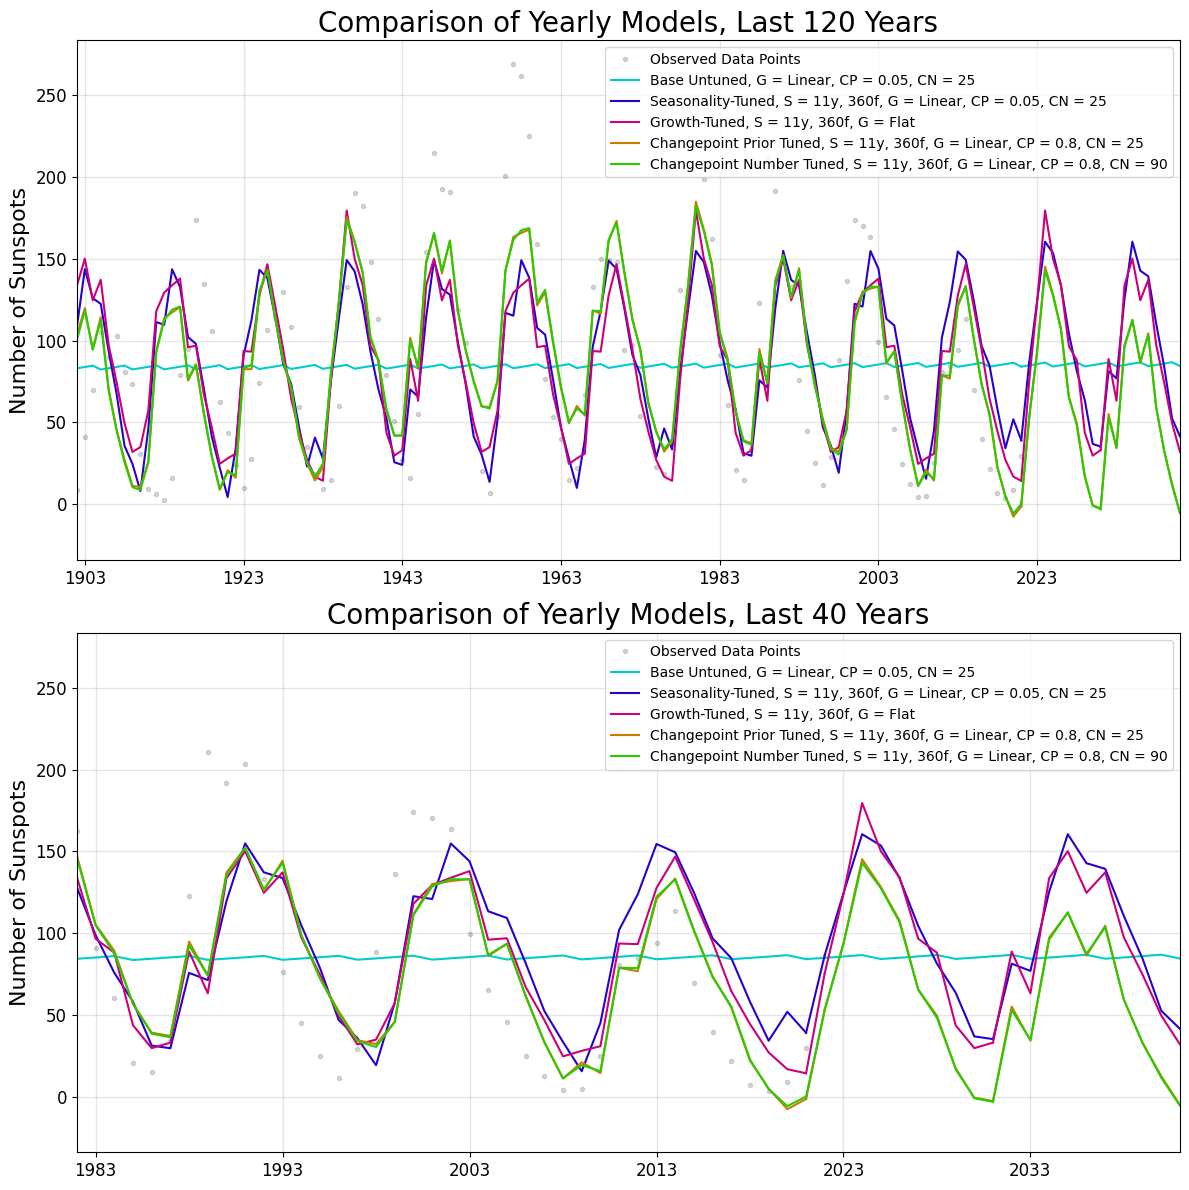

In [18]:
# Compare model predictions at different steps of the tuning process
plot_params = {
    'models': models, 'model_names': model_titles, 'forecasts': forecasts,
    'prior_periods': [120, 40], 'prediction_periods': future_periods,
    'titles': [
        'Comparison of Yearly Models, Last 120 Years',
        'Comparison of Yearly Models, Last 40 Years'
    ]}

ev.plot_model_comparisons(**plot_params);

The best yearly model appears to lag behind the data and is predicting roughly the same average and magnitude for every cycle. It appears to have a magnitude correctly calibrated for the most recent data, so its predictions may be somewhat accurate for the near future.

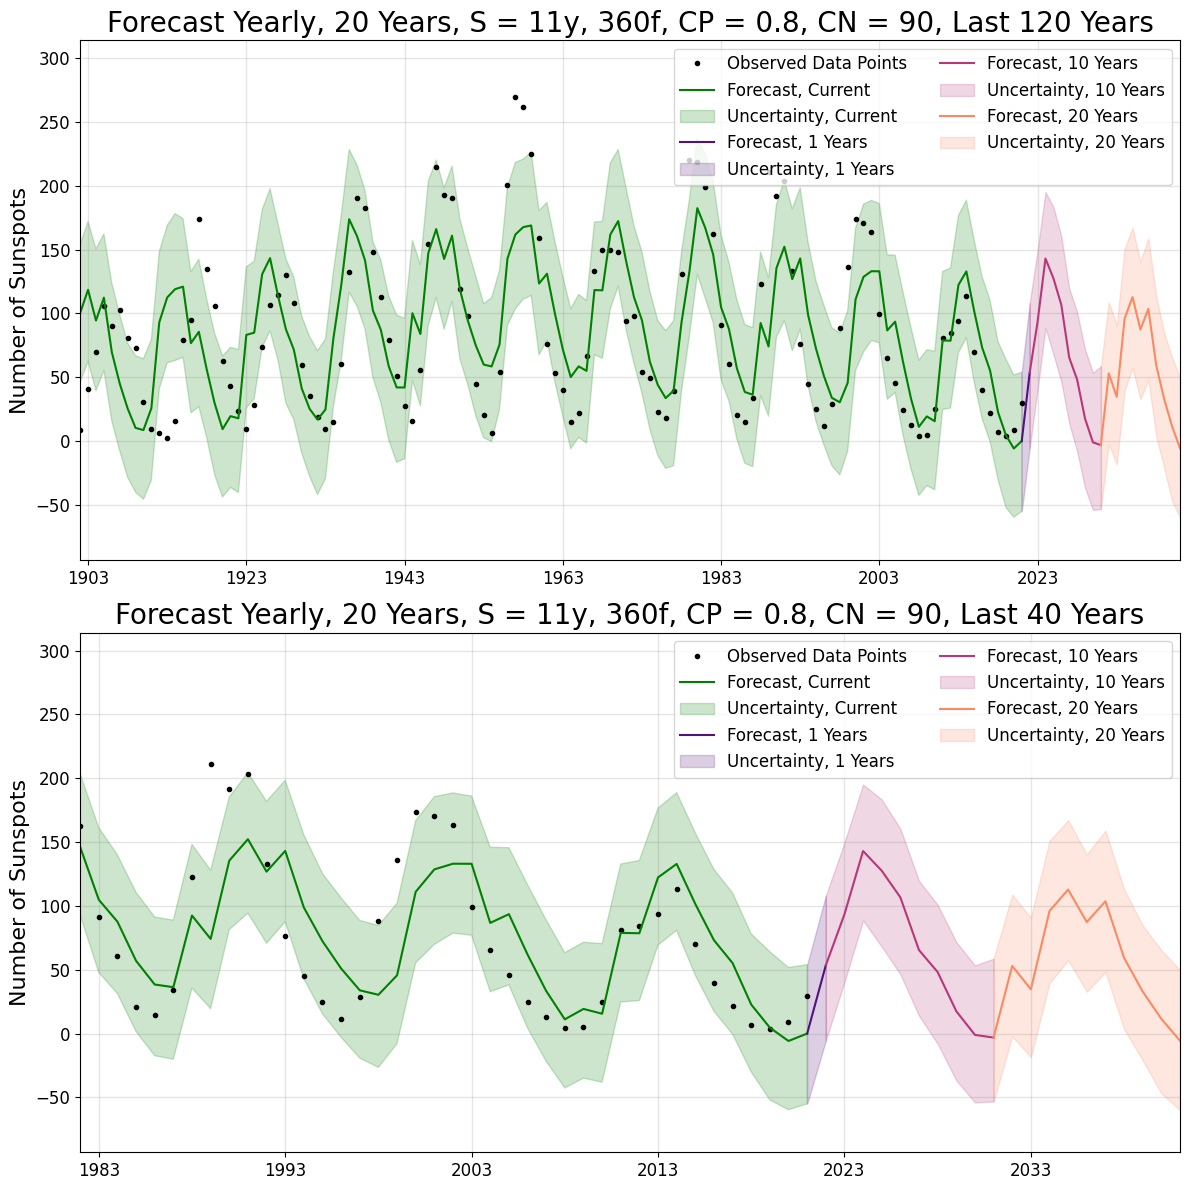

In [19]:
# Plotting best model predictions
idx = -1

plot_params = {
    'model': models[idx], 'current_fc': forecasts[idx][0], 'future_fc': forecasts[idx][1],
    'prior_periods': [120, 40], 'prediction_periods': future_periods,
    'uncertainties': True, 'periodicity': periodicity,
    'titles': [
        'Forecast Yearly, 20 Years, S = 11y, 360f, CP = 0.8, CN = 90, Last 120 Years',
        'Forecast Yearly, 20 Years, S = 11y, 360f, CP = 0.8, CN = 90, Last 40 Years'
    ]}

ev.plot_multi_timeframes(**plot_params);

Although the high fourier order of the seasonality was helpful for getting a better fit, the seasonality is interestingly fairly flat and does not appear to capture the entire solar magnetic half-cycle across the entire length of the known seasonality. The trend is also surprisingly smooth given the high changepoint prior value and number of changepoints selected, and it appears to be entirely wrong, showing an increase in the number of sunspots over time - the opposite of what the data appears to suggest.

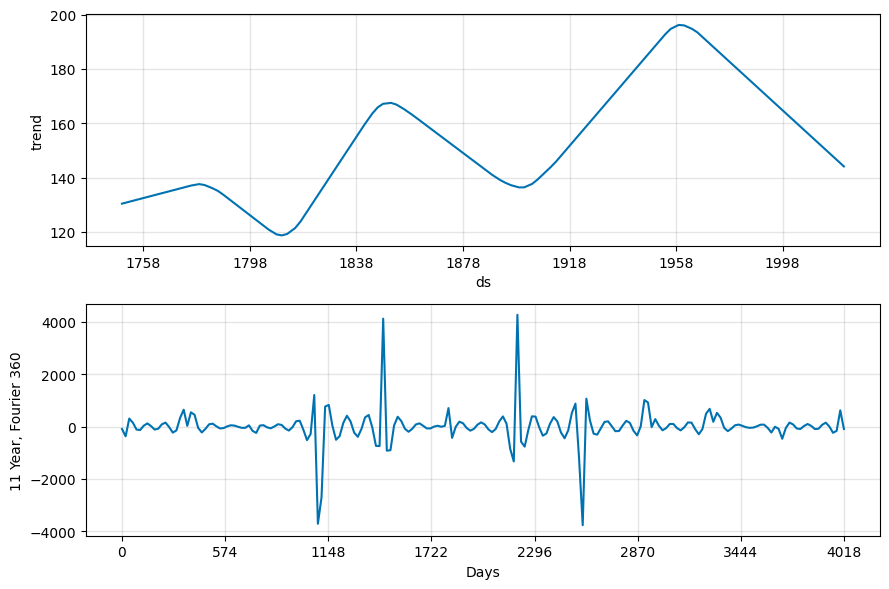

In [20]:
# Looking at best model components
models[idx].plot_components(forecasts[idx][0], uncertainty = False);